In [1]:
from rsnn.new.optim import Solver

In [ ]:
rng = np.random.default_rng()

In [ ]:
solver = Solver

In [82]:
rng = np.random.default_rng()

n_neurons = 10
n_intervals = 7
z = rng.random((n_intervals, n_neurons, 5))

In [84]:
n_indices = np.arange(n_neurons)
sorter = np.argsort(z[:, :, 0], axis=0)
for n in sorter:
    z[n, n_indices, 0]
# z_sorted = np.take_along_axis(z[:, :, 0], sorter, axis=1)

[0.16974197 0.00777036 0.09895137 0.28783169 0.23870346 0.03698644
 0.04945337 0.00926081 0.03568797 0.06445547]
[0.21474239 0.36187624 0.28063472 0.31298028 0.40270559 0.18008878
 0.1580503  0.02086519 0.1133595  0.06477371]
[0.44458149 0.46129236 0.39273045 0.46516346 0.41233506 0.2751952
 0.17319431 0.25360707 0.13345003 0.09874241]
[0.52552854 0.47604381 0.47736396 0.49045374 0.42462954 0.38402634
 0.18145966 0.27887272 0.39181924 0.1639625 ]
[0.81877622 0.58928158 0.80266153 0.53093781 0.59196205 0.48132507
 0.27879558 0.40589598 0.39462239 0.46345171]
[0.83292689 0.70498227 0.95109669 0.61604932 0.66065802 0.48908287
 0.82581044 0.47363822 0.46106185 0.60503221]
[0.93858264 0.76759289 0.96490029 0.83739688 0.77125454 0.86815647
 0.89849953 0.63058661 0.52780814 0.76048868]


In [56]:
indices = np.apply_along_axis(np.searchsorted, 1, z_sorted, 0.5, side='right')

In [100]:
%%timeit
n_neurons = 10000
z = rng.random(n_neurons)
z[:9000] = np.nan

40.6 μs ± 396 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [114]:
z = rng.random(10)
print(z)
select = z < 0.5
print(z[select])
select[select] = z[select] < 0.25
print(z[select])
select[select] = z[select] < 0.125
print(z[select])

[0.35560178 0.07803976 0.59425281 0.70037551 0.19253267 0.75321966
 0.85110569 0.31909798 0.22890583 0.91457474]
[0.35560178 0.07803976 0.19253267 0.31909798 0.22890583]
[0.07803976 0.19253267 0.22890583]
[0.07803976]


In [124]:
n_neurons = 10
f_times = np.full(n_neurons, np.nan, dtype=np.float64)
n_indices = np.arange(n_neurons)

# flag = np.full_like(n_indices, False, dtype=bool)

# corresponds to n_indices
f_times[n_indices] = np.array([0.1, 0.2, np.nan, 0.4, np.nan, 0.6, 0.7, np.nan, 0.9, np.nan])
n_indices = self.n_indices[np.isnan(f_times)]
print(select, f_times, n_indices)

new_f_times = np.array([0.1, 0.2, 0.9, np.nan])
select = np.argwhere(np.isfinite(new_f_times)).flatten()
n_indices = n_indices[select]
f_times[n_indices] = new_f_times[select]
print(select, f_times, n_indices)

[nan nan nan nan nan nan nan nan nan nan]
[0 1 3 5 6 8] [0.1 0.2 nan 0.4 nan 0.6 0.7 nan 0.9 nan] [0 1 3 5 6 8]
[0 1 2] [0.1 0.2 nan 0.9 nan 0.6 0.7 nan 0.9 nan] [0 1 3]


In [161]:
n_neurons, n_intervals = 100, 10000

rng = np.random.default_rng()
st_start = rng.random((n_intervals, n_neurons))

f_times = np.array([0.1, 0.8], dtype=np.float64)
f_sources = np.array([0, 2], dtype=np.int64)

mask = st_start[:, f_sources] < f_times[None, :]
st_start[:, f_sources] = np.where(mask, np.nan, st_start[:, f_sources])
st_start

array([[0.58516633, 0.98722051,        nan, ..., 0.55249069, 0.61827651,
        0.82073246],
       [0.19325732, 0.60985637,        nan, ..., 0.33894068, 0.66045856,
        0.27900049],
       [0.72111023, 0.98167254,        nan, ..., 0.61463166, 0.67597884,
        0.97380646],
       ...,
       [       nan, 0.72527065, 0.98853697, ..., 0.43243181, 0.68747307,
        0.10374071],
       [0.42583746, 0.71751554,        nan, ..., 0.17710458, 0.28318315,
        0.76829341],
       [0.49737894, 0.01153318,        nan, ..., 0.9906981 , 0.03230087,
        0.1043464 ]], shape=(10000, 100))

In [ ]:
import numpy as np
from typing import Tuple
import numpy.typing as npt
from scipy.special import lambertw
from scipy.sparse.csgraph import floyd_warshall

from numba import njit, prange

FIRING_THRESHOLD = 1.0
REFRACTORY_RESET = -1.0
N_STATES = 10000  # Maximum number of states per neuron


def run(
    f_times: npt.NDArray[np.float64],
    f_sources: npt.NDArray[np.int64],
    f_thresh: npt.NDArray[np.float64],
    in_sources: npt.NDArray[np.int64],
    in_delays: npt.NDArray[np.float64],
    in_weights: npt.NDArray[np.float64],
    tmin: float,
    tmax: float,
    f_thresh_std: float = 0.0,
):
    """Run the simulation.

    Warning: This function assumes that the synaptic inputs are sorted by source neuron.

    Args:
        tmin (_type_): _description_
        tmax (_type_): _description_
        f_thresh (_type_): _description_
        in_sources (_type_): _description_
        in_delays (_type_): _description_
        in_weights (_type_): _description_
        f_times (_type_): _description_
        f_sources (_type_): _description_
        f_thresh_std (float, optional): _description_. Defaults to 0.0.
    """
    # Sort the inputs per source neuron and delays
    in_sources, in_delays, in_weights = sort_inputs(in_sources, in_delays, in_weights)

    # Initialize propagation delay matrix (i.e., the minimum delay between each pair of neurons)
    min_delays = init_min_delays(in_sources, in_delays)
    min_delays = floyd_warshall(min_delays, overwrite=True)

    # Initialize states
    st_start, st_c0, st_c1, st_ic0, st_ic1 = init_states(
        in_sources, in_delays, in_weights, f_times, f_sources
    )

    while tmin < tmax:
        # 1. Clean states before tmin
        st_start, st_c0, st_c1, st_ic0, st_ic1 = clean_states(
            tmin, st_start, st_c0, st_c1, st_ic0, st_ic1
        )

        # 2. Sort states (only the removed states have to be placed at the end)
        st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(
            st_start, st_c0, st_c1, st_ic0, st_ic1
        )

        # 3. Calculate next firing times
        new_f_times, new_f_sources = next_f_times(
            f_thresh,
            st_start,
            st_c0,
            st_c1,
            st_ic0,
            st_ic1,
            min_delays,
        )

        # 4. Fire spikes and reset states
        f_times, f_sources, st_start, st_c0, st_c1, st_ic0, st_ic1 = fire_spikes(
            new_f_times,
            new_f_sources,
            # last_f_times,
            f_thresh,
            f_times,
            f_sources,
            st_start,
            st_c0,
            st_c1,
            st_ic0,
            st_ic1,
            f_thresh_std,
        )

        # 5. Propagate spikes through the network
        st_start, st_c0, st_c1, st_ic0, st_ic1 = propagate_spikes(
            new_f_times,
            new_f_sources,
            in_sources,
            in_delays,
            in_weights,
            st_start,
            st_c0,
            st_c1,
            st_ic0,
            st_ic1,
        )

        # 6. Sort states
        st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(
            st_start, st_c0, st_c1, st_ic0, st_ic1
        )

        tmin = np.nanmin(
            new_f_times, initial=np.inf
        )  # if no firings, tmin is set to inf


def init_states(f_times, f_sources, in_sources, in_delays, in_weights):
    n_neurons = in_sources.shape[0]
    st_start = np.full((N_STATES, n_neurons), np.nan, dtype=np.float64)
    st_start[0, :] = -np.inf  # initial state
    st_start[1, :] = np.inf  # final state
    st_c0 = np.zeros_like(st_start, dtype=np.float64)
    st_c1 = np.zeros_like(st_start, dtype=np.float64)
    st_ic0 = np.zeros_like(st_start, dtype=np.float64)
    st_ic1 = np.zeros_like(st_start, dtype=np.float64)

    st_start, st_c0, st_c1, st_ic0, st_ic1 = propagate_spikes(
        f_times,
        f_sources,
        in_sources,
        in_delays,
        in_weights,
        st_start,
        st_c0,
        st_c1,
        st_ic0,
        st_ic1,
    )

    # Determine the last firing times for each source neuron
    last_f_times, last_f_souces = find_last_f_times(f_times, f_sources)

    # Flush the input spikes and reset to the refractory state
    st_start, st_c0, st_c1, st_ic0, st_ic1 = reset_states(
        last_f_times, last_f_souces, st_start, st_c0, st_c1, st_ic0, st_ic1
    )

    return st_start, st_c0, st_c1, st_ic0, st_ic1


@njit(parallel=True)
def init_min_delays(in_sources, in_delays):
    """
    Compute the minimum direct connection delay between all neuron pairs.

    For each postsynaptic neuron `j`, this function finds all presynaptic neurons `i` listed in `in_sources[j]` and records the smallest delay from `i` to `j` in the output matrix.
    If no direct connection exists, the delay remains `np.inf`.

    Parameters
    ----------
    in_sources : ndarray of int64, shape (n_neurons, n_inputs)
        For each postsynaptic neuron (rows), the source neuron IDs of its incoming
        synapses.
        Must be sorted by source ID, and for equal IDs sorted by delay.
    in_delays : ndarray of float64, shape (n_neurons, n_inputs)
        The synaptic delays corresponding to `in_sources`.

    Returns
    -------
    min_delays : ndarray of float64, shape (n_neurons, n_neurons)
        Matrix where entry `(i, j)` is the minimum delay from presynaptic neuron `i` to postsynaptic neuron `j`.
        Entries are `np.inf` if no direct connection exists.
    """

    n_neurons = in_sources.shape[0]
    neurons = np.arange(n_neurons)
    min_delays = np.full((n_neurons, n_neurons), np.inf, dtype=np.float64)
    for l in prange(n_neurons):
        pos = np.searchsorted(in_sources[l], neurons, side="left")
        ids = np.argwhere(in_sources[l, pos] == neurons).flatten()
        min_delays[ids, l] = in_delays[l, pos[ids]]

    return min_delays


def sort_inputs(
    in_sources: npt.NDArray[np.int64],
    in_delays: npt.NDArray[np.float64],
    in_weights: npt.NDArray[np.float64],
) -> Tuple[npt.NDArray[np.int64], npt.NDArray[np.float64], npt.NDArray[np.float64]]:
    """
    Sort each neuron's inputs first by source ID, then by delay.

    Parameters
    ----------
    in_sources : ndarray of int64, shape (n_neurons, n_inputs)
        Source neuron IDs for each postsynaptic neuron.
    in_delays : ndarray of float64, shape (n_neurons, n_inputs)
        Synaptic delays corresponding to `in_sources`.
    in_weights : ndarray of float64, shape (n_neurons, n_inputs)
        Synaptic weights corresponding to `in_sources`.

    Returns
    -------
    in_sources : ndarray of int64
        Source IDs sorted per neuron by (source, delay).
    in_delays : ndarray of float64
        Delays reordered to match the sorted sources.
    in_weights : ndarray of float64
        Weights reordered to match the sorted sources.
    """

    sorter = np.lexsort((in_delays, in_sources), axis=1)
    in_sources = np.take_along_axis(in_sources, sorter, axis=1)
    in_delays = np.take_along_axis(in_delays, sorter, axis=1)
    in_weights = np.take_along_axis(in_weights, sorter, axis=1)
    return in_sources, in_delays, in_weights


def find_last_f_times(f_times, f_sources):
    unique_sources = np.unique(f_sources)
    sorter = np.lexsort((f_times, f_sources))
    indices_last = (
        np.searchsorted(f_sources, unique_sources, side="right", sorter=sorter) - 1
    )
    return f_times[sorter][indices_last], f_sources[sorter][indices_last]


@njit(parallel=True)
def reset_states(f_times, f_sources, st_start, st_c0, st_c1, st_ic0, st_ic1):
    """Reset the states of the neurons that fire.


    Args:
        f_times (npt.NDArray[np.float64]): The firing times for the neurons.
        f_sources (npt.NDArray[np.int64]): The source neurons for the firings.
    """

    for n in prange(f_sources.size):
        l, ft = f_sources[n], f_times[n]
        ipos = np.searchsorted(st_start[:, l], ft, side="left")
        st_start[1:ipos, l] = np.nan
        st_start[-1, l] = ft
        st_c0[-1, l] = REFRACTORY_RESET
        st_ic0[-1, l] = REFRACTORY_RESET

    return st_start, st_c0, st_c1, st_ic0, st_ic1


@njit(parallel=True)
def clean_states(tmin, st_start, st_c0, st_c1, st_ic0, st_ic1):
    """
    Consolidate all states occurring before `tmin` into the last state before `tmin`, and remove (mark as NaN) earlier states.

    This function is designed for per-neuron state histories that are:
    - **Sorted** along the first axis by their start time (`st_start`).
    - **Framed** by an initial state at `-np.inf` (index 0) and a final state at `np.inf` (right before the trailing NaNs).

    For each neuron:
      1. Find the index of the most recent state before `tmin`.
      2. Accumulate contributions from all previous states into that state's coefficients (`st_c0`, `st_c1`).
      3. Mark all earlier states (rows 1 to that index) as removed by setting their `st_start` entries to `NaN`.

    Parameters
    ----------
    tmin : float
        The cutoff time. Only the last state before this time is preserved.
    st_start : ndarray of shape (n_states, n_neurons)
        Start times for each state (must be sorted along axis 0, with NaNs trailing).
    st_c0 : ndarray of shape (n_states, n_neurons)
        First-order cumulative coefficients (will be updated in place).
    st_c1 : ndarray of shape (n_states, n_neurons)
        Second-order cumulative coefficients (will be updated in place).
    st_ic0 : ndarray of shape (n_states, n_neurons)
        First-order independent coefficients (used for recursive updates).
    st_ic1 : ndarray of shape (n_states, n_neurons)
        Second-order independent coefficients (used for recursive updates).

    Returns
    -------
    (st_start, st_c0, st_c1, st_ic0, st_ic1) : tuple of ndarrays
        The same arrays, modified in place:
        - All states before `tmin` are removed except the last one.
        - Coefficients of the preserved state now include contributions from the removed states.
    """
    n_neurons = st_start.shape[1]
    for l in prange(n_neurons):
        ipos = (
            np.searchsorted(st_start[:, l], tmin, side="right") - 1
        )  # always >= 0 since -np.inf is at the start

        st_c0[ipos, l] = st_ic0[ipos, l]
        st_c1[ipos, l] = st_ic1[ipos, l]

        for j in range(1, ipos):
            dt = st_start[ipos, l] - st_start[j, l]

            st_c0[ipos, l] += st_ic0[j, l] * np.exp(-dt)
            st_c0[ipos, l] += st_ic1[j, l] * dt * np.exp(-dt)
            st_c1[ipos, l] += st_ic1[j, l] * np.exp(-dt)

        st_start[1:ipos, l] = np.nan

    return st_start, st_c0, st_c1, st_ic0, st_ic1


def sort_states(
    st_start: npt.NDArray[np.float64],
    st_c0: npt.NDArray[np.float64],
    st_c1: npt.NDArray[np.float64],
    st_ic0: npt.NDArray[np.float64],
    st_ic1: npt.NDArray[np.float64],
) -> Tuple[
    npt.NDArray[np.float64],
    npt.NDArray[np.float64],
    npt.NDArray[np.float64],
    npt.NDArray[np.float64],
    npt.NDArray[np.float64],
]:
    """
    Sort all states of each neuron by their start times (`st_start`).
    The order of the other state arrays (`st_c0`, `st_c1`, `st_ic0`, `st_ic1`) is adjusted accordingly.

    The sort order is:
    - `-np.inf` (initial state)
    - All finite values (sorted ascending)
    - `np.inf` (final state)
    - `NaN` (removed states)

    Parameters
    ----------
    st_start : ndarray of shape (n_states, n_neurons)
        Start times for each state (must be sorted along axis 0).
    st_c0 : ndarray of shape (n_states, n_neurons)
        First-order cumulative coefficients.
    st_c1 : ndarray of shape (n_states, n_neurons)
        Second-order cumulative coefficients.
    st_ic0 : ndarray of shape (n_states, n_neurons)
        First-order independent coefficients.
    st_ic1 : ndarray of shape (n_states, n_neurons)
        Second-order independent coefficients.

    Returns
    -------
    (st_start, st_c0, st_c1, st_ic0, st_ic1) : tuple of ndarrays
        A sorted copy of the provided arrays.
    """
    sorter = np.argsort(st_start, axis=0)
    st_start = np.take_along_axis(st_start, sorter, axis=0)
    st_c0 = np.take_along_axis(st_c0, sorter, axis=0)
    st_c1 = np.take_along_axis(st_c1, sorter, axis=0)
    st_ic0 = np.take_along_axis(st_ic0, sorter, axis=0)
    st_ic1 = np.take_along_axis(st_ic1, sorter, axis=0)
    return st_start, st_c0, st_c1, st_ic0, st_ic1


def first_crossing(
    start,
    length,
    c0,
    c1,
    f_thresh,
) -> np.ndarray:
    """
    Calculate the first (ascending) crossing time of the states defined by the coefficients `c0` and `c1` with the threshold `f_thresh`, in their respective time intervals.
    If a crossing does not occur within the interval, NaN is returned for that state.

    Parameters
    ----------
    start : ndarray of shape (n_states,)
        Start times for each state.
    length : ndarray of shape (n_states,)
        Lengths of the states for each state.
    c0 : ndarray of shape (n_states,)
        First-order coefficients for each state.
    c1 : ndarray of shape (n_states,)
        Second-order coefficients for each state.
    f_thresh : ndarray of shape (n_states,)
        Firing threshold for each state.

    Returns
    -------
    np.ndarray
        First crossing times for each state.
    """

    dt0 = -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), 0)) - c0 / c1
    dt1 = -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), -1)) - c0 / c1
    dt2 = np.log(c0 / f_thresh)

    new_f_times = np.where(
        c0 < f_thresh,
        np.where(
            c1 > 0,
            np.where(
                np.isreal(dt0) & (dt0 >= 0.0) & (dt0 < length), start + dt0.real, np.nan
            ),
            np.where(
                c1 < 0,
                np.where(
                    np.isreal(dt1) & (dt1 >= 0.0) & (dt1 < length),
                    start + dt1.real,
                    np.nan,
                ),
                np.where((dt2 >= 0.0) & (dt2 < length), start + dt2, np.nan),
            ),
        ),
        start,
    )
    return new_f_times


def next_f_times(f_thresh, st_start, st_c0, st_c1, st_ic0, st_ic1, min_delays):
    """
    Calculate the next (causally independent) firings produced in the network, among all neurons.

    Warning: This function requires the states to be sorted by st_start.

    Returns:
        Tuple[npt.NDArray[np.float64], npt.NDArray[np.int64]]: A tuple containing:
            - f_times: Array of firing times.
            - f_sources: Array of firing sources (neuron indices).
    """
    n_intervals, n_neurons = st_start.shape
    f_times = np.full(n_neurons, np.nan, dtype=np.float64)
    max_f_times = np.full(n_neurons, np.inf, dtype=np.float64)
    n_indices = np.arange(n_neurons)
    nf_indices = n_indices[:]

    for n in range(1, n_intervals - 1):  # st_start
        # early exit if no neuron can possibly fire
        if nf_indices.size == 0:
            break

        # update the coefficients
        prev_length = st_start[n, nf_indices] - st_start[n - 1, nf_indices]
        st_c0[n, nf_indices] = (
            st_c0[n - 1, nf_indices]
            + np.nan_to_num(prev_length) * st_c1[n - 1, nf_indices]
        ) * np.exp(-(prev_length)) + st_ic0[n, nf_indices]
        st_c1[n, nf_indices] = (
            st_c1[n - 1, nf_indices] * np.exp(-(prev_length)) + st_ic1[n, nf_indices]
        )

        # update the candidate firing times
        f_times[nf_indices] = first_crossing(
            st_start[n, nf_indices],
            np.clip(
                st_start[n + 1, nf_indices],
                None,
                max_f_times[nf_indices],
            )
            - st_start[n, nf_indices],
            st_c0[n, nf_indices],
            st_c1[n, nf_indices],
            f_thresh[nf_indices],
        )

        # update the maximum firing times
        max_f_times = np.nanmin(
            np.nan_to_num(f_times[None, :], nan=np.inf)
            + min_delays,  # can be further optimized... use Numba???
            initial=np.inf,
            axis=1,
        )

        # update the indices of the neurons that can possibly fire
        nf_indices = n_indices[np.isnan(f_times) & (st_start[n] < max_f_times)]

    f_sources = np.argwhere(f_times <= max_f_times).flatten()
    f_times = f_times[f_sources]
    return f_times, f_sources


def fire_spikes(
    new_f_times,
    new_f_sources,
    f_thresh,
    f_times,
    f_sources,
    st_start,
    st_c0,
    st_c1,
    st_ic0,
    st_ic1,
    f_thresh_std=0.0,
):
    # Concatenate the new firing times and sources with the existing ones
    f_times = np.concatenate((f_times, new_f_times))
    f_sources = np.concatenate((f_sources, new_f_sources))

    # Flush the input spikes and reset to the refractory state
    st_start, st_c0, st_c1, st_ic0, st_ic1 = reset_states(
        new_f_times, new_f_sources, st_start, st_c0, st_c1, st_ic0, st_ic1
    )

    # Apply threshold noise
    f_thresh[f_sources] = rng.normal(
        FIRING_THRESHOLD, f_thresh_std, size=f_sources.size
    )

    return f_times, f_sources, st_start, st_c0, st_c1, st_ic0, st_ic1


@njit(parallel=True)
def propagate_spikes(
    new_f_times,
    new_f_sources,
    in_sources,
    in_delays,
    in_weights,
    st_start,
    st_c0,
    st_c1,
    st_ic0,
    st_ic1,
):
    """
    Propagate new spikes through the network.
    Add new states at the end of the state arrays...

    Warning: This function assumes that the synaptic inputs are sorted by source neuron. Moreover, the states should be large enough to not overwrite existing states...

    Args:
        new_f_times (_type_): _description_
        new_f_sources (_type_): _description_
        in_sources (_type_): _description_
        in_delays (_type_): _description_
        in_weights (_type_): _description_
        st_start (_type_): _description_
        st_c0 (_type_): _description_
        st_c1 (_type_): _description_
        st_ic0 (_type_): _description_
        st_ic1 (_type_): _description_

    Returns:
        _type_: _description_
    """

    for l in range(in_sources.shape[0]):
        start_idx = np.searchsorted(in_sources[l], new_f_sources, side="left")
        end_idx = np.searchsorted(in_sources[l], new_f_sources, side="right")

        pos = -1
        for n in range(new_f_sources.shape[0]):
            num = end_idx[n] - start_idx[n]
            st_start[pos - num : pos, l] = (
                new_f_times[n] + in_delays[l, start_idx[n] : end_idx[n]]
            )
            # st_c0[pos - num : pos, l] = 0.0  # useless
            # st_c1[pos - num : pos, l] = 0.0  # useless
            st_ic0[pos - num : pos, l] = 0.0
            st_ic1[pos - num : pos, l] = in_weights[l, start_idx[n] : end_idx[n]]
            pos -= num

    return st_start, st_c0, st_c1, st_ic0, st_ic1

In [125]:
from typing import Optional, Tuple

import numpy as np
import numpy.typing as npt
from numba import njit
from scipy.special import lambertw

@njit
def scan_states_inplace(
    start: npt.NDArray[np.float64],
    c0: npt.NDArray[np.float64],
    c1: npt.NDArray[np.float64],
    ic0: npt.NDArray[np.float64],
    ic1: npt.NDArray[np.float64],
):
    """
    Scan the states over time, updating the coefficients `c0` and `c1` based on the initial independent coefficients `ic0` and `ic1`.

    Parameters
    ----------
    start : ndarray of shape (n_states, n_others)
        Start times for each state (must be sorted along axis 0, with NaNs trailing).
    c0 : ndarray of shape (n_states, n_others)
        First-order cumulative coefficients (will be updated in place).
    c1 : ndarray of shape (n_states, n_others)
        Second-order cumulative coefficients (will be updated in place).
    ic0 : ndarray of shape (n_states, n_others)
        First-order independent coefficients (used for recursive updates).
    ic1 : ndarray of shape (n_states, n_others)
        Second-order independent coefficients (used for recursive updates).
    """
    n_states = start.shape[0]

    for n in range(1, n_states):
        update_state_inplace(
            start[n],
            c0[n],
            c1[n],
            ic0[n],
            ic1[n],
            start[n - 1],
            c0[n - 1],
            c1[n - 1],
        )
        # length = start - start[n - 1]
        # c0[n] = ic0[n] + (c0[n - 1] + c1[n - 1] * length) * np.exp(-(length))
        # c1[n] = ic1[n] + c1[n - 1] * np.exp(-(length))


@njit
def update_state_inplace(
    start: npt.NDArray[np.float64],
    c0: npt.NDArray[np.float64],
    c1: npt.NDArray[np.float64],
    ic0: npt.NDArray[np.float64],
    ic1: npt.NDArray[np.float64],
    prev_start: npt.NDArray[np.float64],
    prev_c0: npt.NDArray[np.float64],
    prev_c1: npt.NDArray[np.float64],
):
    length = start - prev_start
    exp_length = np.exp(-length)

    np.copyto(c0, ic0)
    c0 += (prev_c0 + prev_c1 * length) * exp_length

    np.copyto(c1, ic1)
    c1 += prev_c1 * exp_length

    return start, c0, c1, ic0, ic1


In [1]:
import numpy as np
from rsnn.new.optim import Solver

In [4]:
rng = np.random.default_rng()

f_times = np.array([], dtype=np.float64)
in_times = rng.uniform(0.0, 10.0, size=10)
in_sources = rng.integers(0, 5, size=10)
period = 10.0
solver = Solver(f_times, in_times, in_sources, period)

2025-07-30 18:43:07.021' - INFO - Initializing state: start.shape=(), ic0.shape=(6,), ic1.shape=(6,), prev_start.shape=(12,), prev_ic0.shape=(12, 6), prev_ic1.shape=(12, 6)
2025-07-30 18:43:07.023' - INFO - Length: length.shape=(12,), Exp decay: exp_decay.shape=(12,)
2025-07-30 18:43:07.023' - INFO - Sum: np.sum((prev_ic1 * length[:, np.newaxis]), axis=0).shape=(6,)
2025-07-30 18:43:07.024' - INFO - Initializing state: start.shape=(), ic0.shape=(6,), ic1.shape=(6,), prev_start.shape=(12,), prev_ic0.shape=(12, 6), prev_ic1.shape=(12, 6)
2025-07-30 18:43:07.024' - INFO - Length: length.shape=(12,), Exp decay: exp_decay.shape=(12,)
2025-07-30 18:43:07.025' - INFO - Sum: np.sum((prev_ic1 * length[:, np.newaxis]), axis=0).shape=(6,)
2025-07-30 18:43:07.026' - INFO - Initializing state: start.shape=(), ic0.shape=(6,), ic1.shape=(6,), prev_start.shape=(12,), prev_ic0.shape=(12, 6), prev_ic1.shape=(12, 6)
2025-07-30 18:43:07.026' - INFO - Length: length.shape=(12,), Exp decay: exp_decay.shape=

In [1]:
import numpy as np
from rsnn.new.utils import scan_states_inplace, init_from_prev_states

rng = np.random.default_rng()

In [4]:
start = np.sort(rng.random((5, 1)), axis=0)
ic0 = rng.random((5, 3))
ic1 = rng.random((5, 3))
c0 = rng.random((5, 3))
c1 = rng.random((5, 3))
scan_states_inplace(start, c0, c1, ic0, ic1)

In [6]:
start = np.sort(rng.random((1, 10, 20)), axis=0)
ic0 = rng.random((4, 10, 20))
ic1 = rng.random((4, 10, 20))
prev_start = np.sort(rng.random((30, 10, 20)), axis=0)
prev_ic0 = rng.random((30, 10, 1))
prev_ic1 = rng.random((30, 1, 20))
_ = init_from_prev_states(start, ic0, ic1, prev_start, prev_ic0, prev_ic1)

In [85]:
import numpy as np
from numba import njit, prange

# def compute_last_f_times_v0(f_times, f_sources):
#     unique_sources = np.unique(f_sources)
#     sorter = np.lexsort((f_times, f_sources))
#     indices_last = np.searchsorted(f_sources, unique_sources, side='right', sorter=sorter) - 1
#     return f_times[sorter][indices_last], f_sources[sorter][indices_last]


def compute_last_f_times_v1(f_times, f_sources):
    unique_sources = np.unique(f_sources)
    sorter = np.lexsort((f_times, f_sources))
    indices_last = (
        np.searchsorted(f_sources, unique_sources, side="right", sorter=sorter) - 1
    )
    return f_times[sorter][indices_last], f_sources[sorter][indices_last]

@njit(parallel=True)
def compute_last_f_times_v2(f_times, f_sources):
    last_f_sources = np.unique(f_sources)
    last_f_times = np.empty(last_f_sources.size, dtype=np.float64)
    for l in prange(last_f_sources.size):
        mask = f_sources == last_f_sources[l]
        last_f_times[l] = np.max(f_times[mask])
    return last_f_times, last_f_sources


@njit
def compute_last_f_times_v3(f_times, f_sources):
    last_f_sources = np.unique(f_sources)
    last_f_times = np.empty(last_f_sources.size, dtype=np.float64)
    for l in prange(last_f_sources.size):
        mask = f_sources == last_f_sources[l]
        last_f_times[l] = np.max(f_times[mask])
    return last_f_times, last_f_sources

def compute_last_f_times_v4(f_times, f_sources):
    last_f_sources = np.unique(f_sources)
    last_f_times = np.empty(last_f_sources.size, dtype=np.float64)
    for l in prange(last_f_sources.size):
        last_f_times[l] = np.max(f_times, where=(f_sources == last_f_sources[l]), initial=np.nan)
    return last_f_times, last_f_sources

In [43]:
rng = np.random.default_rng()

f_sources = rng.integers(0, 3, size=7)
f_times = rng.random(7)
f_times, f_sources

(array([0.74615112, 0.99951555, 0.41981324, 0.84229557, 0.3104125 ,
        0.09552725, 0.63867957]),
 array([0, 2, 0, 2, 2, 2, 2]))

In [44]:
n_sources = 1000
n_spikes = 10000
f_sources = rng.integers(0, n_sources, size=n_spikes)
f_times = rng.random(n_spikes)
last_f_times_v1, last_f_sources_v1 = compute_last_f_times_v1(f_times, f_sources)
last_f_times_v2, last_f_sources_v2 = compute_last_f_times_v2(f_times, f_sources)
last_f_times_v3, last_f_sources_v3 = compute_last_f_times_v3(f_times, f_sources)
last_f_times_v4, last_f_sources_v4 = compute_last_f_times_v3(f_times, f_sources)
np.allclose(last_f_times_v1, last_f_times_v2), np.allclose(last_f_sources_v1, last_f_sources_v2), np.allclose(last_f_times_v1, last_f_times_v3), np.allclose(last_f_sources_v1, last_f_sources_v3), np.allclose(last_f_times_v1, last_f_times_v4), np.allclose(last_f_sources_v1, last_f_sources_v4)

(True, True, True, True, True, True)

In [45]:
%%timeit
n_sources = 1000
n_spikes = 10000
f_sources = rng.integers(0, n_sources, size=n_spikes)
f_times = rng.random(n_spikes)

73.2 μs ± 540 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [46]:
%%timeit
n_sources = 1000
n_spikes = 10000
f_sources = rng.integers(0, n_sources, size=n_spikes)
f_times = rng.random(n_spikes)
compute_last_f_times_v1(f_times, f_sources)

1.67 ms ± 1.22 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [47]:
%%timeit
n_sources = 1000
n_spikes = 10000
f_sources = rng.integers(0, n_sources, size=n_spikes)
f_times = rng.random(n_spikes)
compute_last_f_times_v2(f_times, f_sources)

3.87 ms ± 68.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [48]:
%%timeit
n_sources = 1000
n_spikes = 10000
f_sources = rng.integers(0, n_sources, size=n_spikes)
f_times = rng.random(n_spikes)
compute_last_f_times_v3(f_times, f_sources)

12.1 ms ± 130 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%%timeit
n_sources = 1000
n_spikes = 10000
f_sources = rng.integers(0, n_sources, size=n_spikes)
f_times = rng.random(n_spikes)
compute_last_f_times_v4(f_times, f_sources)

10.5 ms ± 20.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
n_neurons = 5
n_inputs = 10
in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs))
in_delays = rng.random(size=(n_neurons, n_inputs))
in_weights = rng.random(size=(n_neurons, n_inputs))
in_sources, in_delays, in_weights = sort_inputs(in_sources, in_delays, in_weights)
in_sources[0], in_delays[0], in_weights[0]

(array([1, 1, 2, 2, 2, 3, 3, 3, 4, 4]),
 array([0.37248361, 0.72080482, 0.27072975, 0.57580257, 0.86778332,
        0.18034131, 0.50518758, 0.8102312 , 0.23753681, 0.47156092]),
 array([0.97080782, 0.60906615, 0.52283992, 0.46965223, 0.79220772,
        0.06060525, 0.06692266, 0.83175879, 0.45203601, 0.78138163]))

In [ ]:
@njit(parallel=True)
def init_min_delays_v1(in_sources, in_delays):
    """
    Initialize the minimum delays between neurons, based on direct synaptic connections.
    Connections need to be sorted by source neuron.

    Parameters
    ----------
    in_sources : _type_
        _description_
    in_delays : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    # Faster than the broadcasted version, but requires numba
    n_neurons = in_sources.shape[0]
    neurons = np.arange(n_neurons)
    min_delays = np.full((n_neurons, n_neurons), np.inf, dtype=np.float64)

    for l in prange(n_neurons):
        start_idx = np.searchsorted(in_sources[l], neurons, side="left")
        end_idx = np.searchsorted(in_sources[l], neurons, side="right")
        len_idx = end_idx - start_idx
        for n in range(n_neurons):
            if len_idx[n] > 0:
                min_delays[n, l] = np.min(in_delays[l, start_idx[n] : end_idx[n]])
    return min_delays

@njit(parallel=True)
def init_min_delays_v2(in_sources, in_delays):
    # unique_sources = np.unique(f_sources)
    n_neurons = in_sources.shape[0]
    neurons = np.arange(n_neurons)
    min_delays = np.full((n_neurons, n_neurons), np.inf, dtype=np.float64)
    for l in prange(n_neurons):
        pos = np.searchsorted(in_sources[l], neurons, side="left")
        ids = np.argwhere(in_sources[l, pos] == neurons).flatten()
        min_delays[ids, l] = in_delays[l, pos[ids]]

    return min_delays

In [105]:
n_neurons = 3
n_inputs = 3

In [106]:
in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs))
in_delays = rng.random(size=(n_neurons, n_inputs))
in_weights = np.zeros_like(in_sources, dtype=np.float64)
in_sources, in_delays, in_weights = sort_inputs(in_sources, in_delays, in_weights)
in_sources, in_delays

(array([[0, 2, 2],
        [0, 2, 2],
        [0, 1, 2]]),
 array([[0.38498873, 0.4221006 , 0.46046332],
        [0.00675285, 0.75397437, 0.9125081 ],
        [0.64756122, 0.74435903, 0.41936447]]))

In [109]:
min_delays_v1 = init_min_delays_v1(in_sources, in_delays)
min_delays_v2 = init_min_delays_v2(in_sources, in_delays)
# np.allclose(min_delays_v1, min_delays_v2)
min_delays_v1, min_delays_v2

(array([[0.38498873, 0.00675285, 0.64756122],
        [       inf,        inf, 0.74435903],
        [0.4221006 , 0.75397437, 0.41936447]]),
 array([[0.38498873, 0.00675285, 0.64756122],
        [       inf,        inf, 0.74435903],
        [0.4221006 , 0.75397437, 0.41936447]]))

In [110]:
n_neurons = 1000
n_inputs = 1000

In [111]:
%%timeit
in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs))
in_delays = rng.random(size=(n_neurons, n_inputs))
in_weights = np.zeros_like(in_sources, dtype=np.float64)
in_sources, in_delays, in_weights = sort_inputs(in_sources, in_delays, in_weights)

95.2 ms ± 1.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [112]:
%%timeit
in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs))
in_delays = rng.random(size=(n_neurons, n_inputs))
in_weights = np.zeros_like(in_sources, dtype=np.float64)
in_sources, in_delays, in_weights = sort_inputs(in_sources, in_delays, in_weights)
min_delays_v1 = init_min_delays_v1(in_sources, in_delays)

119 ms ± 4.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [113]:
%%timeit
in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs))
in_delays = rng.random(size=(n_neurons, n_inputs))
in_weights = np.zeros_like(in_sources, dtype=np.float64)
in_sources, in_delays, in_weights = sort_inputs(in_sources, in_delays, in_weights)
min_delays_v2 = init_min_delays_v2(in_sources, in_delays)

110 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
rng = np.random.default_rng()

n_neurons, n_intervals = 10, 5

st_start = rng.random((n_intervals, n_neurons))
st_start[0] = -np.inf
st_start[1] = np.inf
st_start[87:] = np.nan

st_c0 = rng.random((n_intervals, n_neurons))
st_c1 = rng.random((n_intervals, n_neurons))
st_ic0 = rng.random((n_intervals, n_neurons))
st_ic1 = rng.random((n_intervals, n_neurons))
st_c0[0] = 0.0
st_c1[0] = 0.0
st_c0[1] = 0.0
st_c1[1] = 0.0
st_ic0[0] = 0.0
st_ic1[0] = 0.0
st_ic0[1] = 0.0
st_ic1[1] = 0.0

tmin = 0.5

st_start[:, 0], st_c0[:, 0], st_c1[:, 0]

(array([      -inf,        inf, 0.76612924, 0.18825098, 0.59354093]),
 array([0.        , 0.        , 0.68117217, 0.53775516, 0.88511113]),
 array([0.        , 0.        , 0.8206596 , 0.28156022, 0.43504344]))

In [ ]:
n_neurons, n_intervals = 100, 1000

st_start = rng.random((n_intervals, n_neurons))
st_start[0] = -np.inf
st_start[1] = np.inf
st_start[50:] = np.nan

st_c0 = rng.random((n_intervals, n_neurons))
st_c1 = rng.random((n_intervals, n_neurons))
st_ic0 = rng.random((n_intervals, n_neurons))
st_ic1 = rng.random((n_intervals, n_neurons))
st_c0[0] = 0.0
st_c1[0] = 0.0
st_c0[1] = 0.0
st_c1[1] = 0.0
st_ic0[0] = 0.0
st_ic1[0] = 0.0
st_ic0[1] = 0.0
st_ic1[1] = 0.0
st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(
    st_start,
    st_c0,
    st_c1,
    st_ic0,
    st_ic1,
)
# st_start#, st_c0, st_c1, st_ic0, st_ic1

In [ ]:
n_inputs = 200
new_f_times = np.array([1.0, 2.0], dtype=np.float64)
new_f_sources = np.array([0, 2], dtype=np.int64)

in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs), dtype=np.int64)
in_delays = rng.random((n_neurons, n_inputs), dtype=np.float64)
in_weights = rng.random((n_neurons, n_inputs), dtype=np.float64)

sorter = np.argsort(in_sources, axis=1)
in_sources = np.take_along_axis(in_sources, sorter, axis=1)
in_delays = np.take_along_axis(in_delays, sorter, axis=1)
in_weights = np.take_along_axis(in_weights, sorter, axis=1)

in_min_delays = init_in_min_delays(in_sources, in_delays)
in_min_delays_jit = init_in_min_delays_jit(in_sources, in_delays)

True

In [519]:
%%timeit
n_neurons, n_inputs = 500, 500

in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs), dtype=np.int64)
in_delays = rng.random((n_neurons, n_inputs), dtype=np.float64)
in_weights = rng.random((n_neurons, n_inputs), dtype=np.float64)

sorter = np.argsort(in_sources, axis=1)
in_sources = np.take_along_axis(in_sources, sorter, axis=1)
in_delays = np.take_along_axis(in_delays, sorter, axis=1)
in_weights = np.take_along_axis(in_weights, sorter, axis=1)

12.7 ms ± 215 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [521]:
%%timeit
n_neurons, n_inputs = 500, 500

in_sources = rng.integers(0, n_neurons, size=(n_neurons, n_inputs), dtype=np.int64)
in_delays = rng.random((n_neurons, n_inputs), dtype=np.float64)
in_weights = rng.random((n_neurons, n_inputs), dtype=np.float64)

sorter = np.argsort(in_sources, axis=1)
in_sources = np.take_along_axis(in_sources, sorter, axis=1)
in_delays = np.take_along_axis(in_delays, sorter, axis=1)
in_weights = np.take_along_axis(in_weights, sorter, axis=1)

in_min_delays = init_in_min_delays(in_sources, in_delays)

41 ms ± 4.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
st_start, st_c0, st_c1, st_ic0, st_ic1 = propagate_spikes(
    new_f_times,
    new_f_sources,
    in_sources,
    in_delays,
    in_weights,
    st_start,
    st_c0,
    st_c1,
    st_ic0,
    st_ic1,
)
st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(
    st_start,
    st_c0,
    st_c1,
    st_ic0,
    st_ic1,
)
st_start#, st_c0, st_c1, st_ic0, st_ic1

array([[      -inf,       -inf,       -inf, ...,       -inf,       -inf,
              -inf],
       [0.00049983, 0.02286128, 0.00164919, ..., 0.03696042, 0.03645957,
        0.02844334],
       [0.01092573, 0.11626068, 0.00851518, ..., 0.05998315, 0.07208946,
        0.05281778],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], shape=(1000, 100))

In [ ]:
last_f_times = np.full(n_neurons, np.nan, dtype=np.float64)
f_sources = np.array([], dtype=np.int64)
f_times = np.array([], dtype=np.float64)
new_f_times = np.array([1.0, 2.0], dtype=np.float64)
new_f_sources = np.array([0, 2], dtype=np.int64)
f_thresh = np.ones(n_neurons)
f_thresh_std = 0.1

rng = np.random.default_rng()

n_neurons, n_intervals = 100, 500

st_start = rng.random((n_intervals, n_neurons))
st_start[0] = -np.inf
st_start[1] = np.inf
st_start[87:] = np.nan

st_c0 = rng.random((n_intervals, n_neurons))
st_c1 = rng.random((n_intervals, n_neurons))
st_ic0 = rng.random((n_intervals, n_neurons))
st_ic1 = rng.random((n_intervals, n_neurons))
st_c0[0] = 0.0
st_c1[0] = 0.0
st_c0[1] = 0.0
st_c1[1] = 0.0
st_ic0[0] = 0.0
st_ic1[0] = 0.0
st_ic0[1] = 0.0
st_ic1[1] = 0.0

st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(
    st_start, st_c0, st_c1, st_ic0, st_ic1
)

fire_spikes(
    new_f_times,
    new_f_sources,
    f_thresh,
    last_f_times,
    f_times,
    f_sources,
    st_start,
    st_c0,
    st_c1,
    st_ic0,
    st_ic1,
    f_thresh_std
)

In [ ]:
st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(st_start, st_c0, st_c1, st_ic0, st_ic1)
st_start[:, 1], st_c0[:, 1], st_c1[:, 1]

(array([      -inf, 0.33132625, 0.81407188, 0.93453271,        inf]),
 array([0.        , 0.5707637 , 0.18516339, 0.75993268, 0.        ]),
 array([0.        , 0.39026475, 0.97195349, 0.4247943 , 0.        ]))

In [ ]:
st_start, st_c0, st_c1, st_ic0, st_ic1 = clean_states(0.6, st_start, st_c0, st_c1, st_ic0, st_ic1)
st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(st_start, st_c0, st_c1, st_ic0, st_ic1)
st_start[:, 1], st_c0[:, 1], st_c1[:, 1]

(array([      -inf, 0.33132625, 0.81407188, 0.93453271,        inf]),
 array([0.        , 0.90059055, 0.18516339, 0.75993268, 0.        ]),
 array([0.        , 0.45002497, 0.97195349, 0.4247943 , 0.        ]))

In [313]:
f_times = rng.random(3)
f_sources = rng.choice(n_neurons, 3, replace=False)
f_times, f_sources

(array([0.41774723, 0.77595724, 0.48572907]), array([2, 7, 8]))

In [ ]:
st_start, st_c0, st_c1, st_ic0, st_ic1 = reset_states(f_times, f_sources, st_start, st_c0, st_c1, st_ic0, st_ic1)
st_start, st_c0, st_c1, st_ic0, st_ic1 = sort_states(st_start, st_c0, st_c1, st_ic0, st_ic1)
st_start[:, 1], st_c0[:, 1], st_c1[:, 1]

(array([      -inf, 0.33132625, 0.81407188, 0.93453271,        inf]),
 array([0.        , 0.90059055, 0.18516339, 0.75993268, 0.        ]),
 array([0.        , 0.45002497, 0.97195349, 0.4247943 , 0.        ]))

In [ ]:
f_thresh = np.ones(n_neurons)
in_min_delays = np.zeros((n_neurons, n_neurons), dtype=np.float64)
next_f_times(f_thresh, st_start, st_c0, st_c1, st_ic0, st_ic1, in_min_delays)

/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1337082809.py:68: RuntimeWarning: divide by zero encountered in divide
  dt0 = -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), 0)) - c0 / c1
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1337082809.py:68: RuntimeWarning: invalid value encountered in subtract
  dt0 = -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), 0)) - c0 / c1
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1337082809.py:69: RuntimeWarning: divide by zero encountered in divide
  dt1 = -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), -1)) - c0 / c1
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1337082809.py:69: RuntimeWarning: invalid value encountered in subtract
  dt1 = -(lambertw(-f_thresh / c1 * np.exp(-c0 / c1), -1)) - c0 / c1
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1337082809.py:70: RuntimeWarning: invalid value encountered in log
  dt2 = np.log(c0 / f_thresh)
/var/folders/p1/wl

(array([0.61858868]), array([4]))

In [ ]:
st_start[:,4], st_c0[:,4], st_c1[:,4], st_ic0[:,4], st_ic1[:,4]

(array([      -inf, 0.45408593, 0.61858868,        inf,        nan]),
 array([0.        , 0.19063104, 1.05543714, 0.        , 0.2106498 ]),
 array([0.        , 0.82849784, 0.70537699, 0.        , 0.94974762]),
 array([0.        , 0.19063104, 0.77810483, 0.        , 0.12350953]),
 array([0.        , 0.82849784, 0.00254949, 0.        , 0.39325515]))

In [244]:
def clear_states(f_times, f_sources, st_start, st_c0, st_c1):
    """Clear the states of the neurons that fire.

    Args:
        f_times (npt.NDArray[np.float64]): The firing times for the neurons.
        f_sources (npt.NDArray[np.int64]): The source neurons for the firings.
    """
    # Create a mask for indices to clear
    mask = st_start[:, f_sources] < f_times[None, :]
    st_start[:, f_sources] = np.where(mask, np.nan, st_start[:, f_sources])
    st_c0[:, f_sources] = np.where(mask, 0.0, st_c0[:, f_sources])
    st_c1[:, f_sources] = np.where(mask, 0.0, st_c1[:, f_sources])

    # Refractory mechanism
    st_start[-1, f_sources] = f_times
    st_c0[-1, f_sources] = -100.0

    # Initial state
    st_start[-2, f_sources] = -np.inf

    st_sorter = np.argsort(st_start, axis=0)

    return st_start, st_c0, st_c1, st_sorter

n_neurons, n_intervals = 3, 10

rng = np.random.default_rng()
st_start = rng.random((n_intervals, n_neurons))
st_start[0, :] = -np.inf
st_c0 = np.zeros_like(st_start, dtype=np.float64)
st_c1 = np.zeros_like(st_start, dtype=np.float64)
print("Initial states:")
print("st_start:", st_start)
# print("st_c0:", st_c0)
# print("st_c1:", st_c1)

f_times = np.array([0.1, 0.8])
f_sources = np.array([0, 2])

st_start, st_c0, st_c1, st_sorter = clear_states(f_times, f_sources, st_start, st_c0, st_c1)
print("\nAfter clearing states:")
print("st_start (sorted):", np.take_along_axis(st_start, st_sorter, axis=0))
print("st_c0 (sorted):", np.take_along_axis(st_c0, st_sorter, axis=0))
print("st_c1 (sorted):", np.take_along_axis(st_c1, st_sorter, axis=0))
# print("st_c0:", st_c0)
# print("st_c1:", st_c1)

Initial states:
st_start: [[      -inf       -inf       -inf]
 [0.0621989  0.12540155 0.10581643]
 [0.82126884 0.77082924 0.159497  ]
 [0.91122084 0.73075128 0.11928135]
 [0.68105993 0.17801138 0.13829875]
 [0.80575992 0.6396962  0.61255513]
 [0.80012809 0.64075141 0.62257343]
 [0.04388474 0.88284282 0.16884236]
 [0.64517744 0.5255332  0.74381167]
 [0.79524179 0.36912486 0.35625296]]

After clearing states:
st_start (sorted): [[      -inf       -inf       -inf]
 [0.1        0.12540155 0.8       ]
 [0.68105993 0.17801138        nan]
 [0.80012809 0.36912486        nan]
 [0.80575992 0.5255332         nan]
 [0.82126884 0.6396962         nan]
 [0.91122084 0.64075141        nan]
 [       nan 0.73075128        nan]
 [       nan 0.77082924        nan]
 [       nan 0.88284282        nan]]
st_c0 (sorted): [[   0.    0.    0.]
 [-100.    0. -100.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [   0.    0.    0.]
 [  

In [93]:
def first_crossing_vectorized(
    start, length, c0, c1, threshold
) -> np.ndarray:
    """Vectorized version of first_crossing."""

    dt0 = -(lambertw(-threshold / c1 * np.exp(-c0 / c1), 0)) - c0 / c1
    dt1 = -(lambertw(-threshold / c1 * np.exp(-c0 / c1), -1)) - c0 / c1
    dt2 = np.log(c0 / threshold)

    next_f_times = np.where(
        c0 < threshold,
        np.where(
            c1 > 0,
            np.where(
                np.isreal(dt0) & (dt0 >= 0.0) & (dt0 < length), start + dt0.real, np.nan
            ),
            np.where(
                c1 < 0,
                np.where(
                    np.isreal(dt1) & (dt1 >= 0.0) & (dt1 < length), start + dt1.real, np.nan
                ),
                np.where((dt2 >= 0.0) & (dt2 < length), start + dt2, np.nan),
            ),
        ),
        start,
    )
    return next_f_times

In [96]:
0.11183256 * np.exp(-0.11183256)

np.float64(0.10000000066794654)

In [97]:
start = np.array([5.0, 0.0, 7.0, 0.0, 0.0])
length = np.full_like(start, 10.0)
c0 = np.zeros_like(start)
c1 = np.ones_like(start)
threshold = np.array([-0.1, 0.0, 0.1, 1.0, 10.0])
next_f_times = first_crossing_vectorized(start, length, c0, c1, threshold)
next_f_times

/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1734129474.py:8: RuntimeWarning: invalid value encountered in divide
  dt2 = np.log(c0 / threshold)
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_64995/1734129474.py:8: RuntimeWarning: divide by zero encountered in log
  dt2 = np.log(c0 / threshold)


array([5.        , 0.        , 7.11183256,        nan,        nan])

In [67]:
%%timeit
z = np.sort(rng.random(100000))
i = np.searchsorted(z, 0.9, side='right')
z[:i] = np.nan
# z.sort()

7.08 ms ± 215 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [76]:
z = np.sort(rng.random(10))
z[z < 0.5] = np.nan
z.sort()
z

array([0.61052818, 0.71860566, 0.74390153, 0.77961152,        nan,
              nan,        nan,        nan,        nan,        nan])

In [7]:
%timeit lambertw(z)

456 μs ± 9.59 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
%%timeit
for i in range(1000):
    lambertw(z[i])

3.53 ms ± 83.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [2]:
from rsnn.sim.sim_numba import init_states

In [4]:
n_neurons = 3
f_times = [np.array([0.1, 0.2]), np.array([0.15, 0.25]), np.array([0.05])]
in_sources = np.array([[0, 1], [1, 2]])
in_delays = np.array([[0.01, 0.02], [0.02, 0.03]])
in_weights = np.array([[1.0, 0.5], [0.5, 1.0]])
init_states(n_neurons, f_times, in_sources, in_delays, in_weights)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/haguettaz/Desktop/RSNN/src/rsnn/sim/sim_numba.py:232: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  st_start[n_id] = np.concatenate((st_start[n_id], new_st_start), axis=0)


: 

In [54]:
import numba
from numba import njit, prange
from numba.experimental import jitclass
from numba import float64, int64
import numpy as np

neuron_spec = [("id", int64), ("a", float64)]


@jitclass(neuron_spec)
class Neuron:
    def __init__(self, id, a):
        self.id = id
        self.a = a

    def step(self, tmax, rng):
        t = rng.uniform(0.0, self.a)
        if t > tmax:
            return np.nan
        else:
            return t


network_spec = [("neurons", numba.types.ListType(Neuron.class_type.instance_type))]


@jitclass(network_spec)
class Network:
    def __init__(self, neurons):
        self.neurons = neurons

    def step(self, tmax, rng):
        n = len(self.neurons)
        res = np.empty(n)
        for i in prange(n):
            neuron = self.neurons[i]
            t = rng.uniform(0.0, neuron.a)
            if t > tmax:
                res[i] = np.nan
            else:
                res[i] = t
        return res

In [ ]:
from numba.typed import List as NumbaList

n_neurons = 3  # Number of neurons

f_threshold = np.array([1.0, 1.2, 0.9], dtype=np.float64)  # Firing threshold for each neuron
f_times = NumbaList([np.array([], dtype=np.float64) for _ in range(n_neurons)])  # Firing times for each neuron

# State variables
s_start = NumbaList([np.array([-np.inf, np.inf], dtype=np.float64) for _ in range(n_neurons)])  # Start times of the state
s_length = NumbaList([np.array([np.inf, np.inf]) for _ in range(n_neurons)])  # Length of the state
s_c0 = NumbaList([np.zeros((2,), dtype=np.float64) for _ in range(n_neurons)])  # c0s for each neuron
s_c1 = NumbaList([np.zeros((2,), dtype=np.float64) for _ in range(n_neurons)])  # c1s for each neuron
s_dc0 = NumbaList([np.zeros((2,), dtype=np.float64) for _ in range(n_neurons)])  # dc0s for each neuron
s_dc1 = NumbaList([np.zeros((2,), dtype=np.float64) for _ in range(n_neurons)])  # dc1s for each neuron

# With Numba

In [106]:
@njit(parallel=True)
def clean_states(tmin, n_neurons, s_start, s_c0, s_c1):
    for n in prange(n_neurons):
        ipos = np.searchsorted(s_start[n], tmin, side="right") - 1  # always >= 0

        if ipos > 0:  # if there are states to clean
            for i in range(1, ipos + 1):
                dt = np.nan_to_num(s_start[n][i] - s_start[n][i - 1])
                s_c0[n][i] = (s_c0[n][i - 1] + dt * s_c1[n][i - 1]) * np.exp(
                    -dt
                ) #+ s_dc0[n][i]
                s_c1[n][i] = s_c1[n][i - 1] * np.exp(-dt) # + s_dc1[n][i]

            s_start[n] = s_start[n][ipos - 1 :]
            s_c0[n] = s_c0[n][ipos - 1 :]
            s_c1[n] = s_c1[n][ipos - 1 :]
            # s_dc0[n] = s_dc0[n][ipos - 1 :]
            # s_dc1[n] = s_dc1[n][ipos - 1 :]

            s_start[n][0] = -np.inf
            s_c0[n][0] = 0.0
            s_c1[n][0] = 0.0
            # s_dc0[n][0] = 0.0
            # s_dc1[n][0] = 0.0

            # s_dc0[n][1] = s_c0[n][1]
            # s_dc1[n][1] = s_c1[n][1]

# def next_f_times(f_threshold, s_start, s_length, s_c0, s_c1):


In [107]:
tmin = 2.0
n_neurons = 1000

rng = np.random.default_rng(42)  # Random number generator for reproducibility
s_start, s_c0, s_c1 = NumbaList(), NumbaList(), NumbaList()
for _ in range(n_neurons):
    n_states = rng.integers(100, 200)
    s_start.append(
        np.concatenate(
            [
                np.array([-np.inf]),
                np.sort(rng.uniform(0, 10, n_states)),
                np.array([np.inf]),
            ]
        ),
    )
    s_c0.append(rng.uniform(0, 2, n_states + 2))
    s_c1.append(rng.uniform(0, 2, n_states + 2))

%timeit clean_states(tmin, n_neurons, s_start, s_c0, s_c1)

1.29 ms ± 56.6 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Without Numba

In [108]:
def clean_states(tmin, n_neurons, s_start, s_c0, s_c1):
    for n in range(n_neurons):
        ipos = np.searchsorted(s_start[n], tmin, side="right") - 1  # always >= 0

        if ipos > 0:  # if there are states to clean
            for i in range(1, ipos + 1):
                dt = np.nan_to_num(s_start[n][i] - s_start[n][i - 1])
                s_c0[n][i] = (s_c0[n][i - 1] + dt * s_c1[n][i - 1]) * np.exp(
                    -dt
                ) #+ s_dc0[n][i]
                s_c1[n][i] = s_c1[n][i - 1] * np.exp(-dt) # + s_dc1[n][i]

            s_start[n] = s_start[n][ipos - 1 :]
            s_c0[n] = s_c0[n][ipos - 1 :]
            s_c1[n] = s_c1[n][ipos - 1 :]
            # s_dc0[n] = s_dc0[n][ipos - 1 :]
            # s_dc1[n] = s_dc1[n][ipos - 1 :]

            s_start[n][0] = -np.inf
            s_c0[n][0] = 0.0
            s_c1[n][0] = 0.0
            # s_dc0[n][0] = 0.0
            # s_dc1[n][0] = 0.0

            # s_dc0[n][1] = s_c0[n][1]
            # s_dc1[n][1] = s_c1[n][1]

# def next_f_times(f_threshold, s_start, s_length, s_c0, s_c1):

tmin = 2.0
n_neurons = 1000

rng = np.random.default_rng(42)  # Random number generator for reproducibility
s_start, s_c0, s_c1 = list(), list(), list()
for _ in range(n_neurons):
    n_states = rng.integers(100, 200)
    s_start.append(
        np.concatenate(
            [
                np.array([-np.inf]),
                np.sort(rng.uniform(0, 10, n_states)),
                np.array([np.inf]),
            ]
        ),
    )
    s_c0.append(rng.uniform(0, 2, n_states + 2))
    s_c1.append(rng.uniform(0, 2, n_states + 2))

%timeit clean_states(tmin, n_neurons, s_start, s_c0, s_c1)

/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_74993/1429108501.py:8: RuntimeWarning: overflow encountered in scalar multiply
  s_c0[n][i] = (s_c0[n][i - 1] + dt * s_c1[n][i - 1]) * np.exp(
/var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_74993/1429108501.py:8: RuntimeWarning: invalid value encountered in scalar multiply
  s_c0[n][i] = (s_c0[n][i - 1] + dt * s_c1[n][i - 1]) * np.exp(


22.5 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [109]:
import numpy as np

In [131]:
rng = np.random.default_rng(42)  # Random number generator for reproducibility
f_times = np.array([0.0, 0.3, 0.2])
f_sources = np.array([0, 4, 8])
in_sources = rng.integers(0, 10, size=(10, 5))
in_delays = rng.uniform(0, 5, size=(10, 5))
in_weights = rng.uniform(-1, 1, size=(10, 5))

In [138]:
in_sources[0], in_delays[0],f_sources, f_times

(array([0, 7, 6, 4, 4]),
 array([0.97319354, 2.33360502, 0.21901883, 0.77144746, 3.41524477]),
 array([0, 4, 8]),
 array([0. , 0.3, 0.2]))

In [135]:
indices = np.argwhere(f_sources[:, None] == in_sources[0][None, :])
f_times[indices[:, 0]]

array([0. , 0.3, 0.3])

In [137]:
indices = np.argwhere(f_sources[:, None] == in_sources[0][None, :])
start = f_times[indices[:, 0]] + in_delays[0, indices[:, 1]]
start

array([0.97319354, 1.07144746, 3.71524477])

In [117]:
select = f_sources[None,:] == in_sources[0][:,None]
in_delays[select]


IndexError: boolean index did not match indexed array along axis 0; size of axis is 10 but size of corresponding boolean axis is 5

In [57]:
from numba.typed import List



In [58]:
neurons = List()
for l in range(100):
    neurons.append(Neuron(l, np.random.uniform(0.0, 10.0)))
net = Network(neurons)

In [60]:
%timeit net.step(5.0, np.random.default_rng(42))

67.2 μs ± 2.11 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
class Neuron:
    def __init__(self, id, a):
        self.id = id
        self.a = a

    def step(self, tmax, rng):
        t = rng.uniform(0.0, self.a)
        if t > tmax:
            return np.nan
        else:
            return t
        
class Network:
    def __init__(self, neurons):
        self.neurons = neurons

    @property
    def n_neurons(self):
        return len(self.neurons)

    @njit
    def step(self, tmax, rng):
        res = np.empty(self.n_neurons)
        for i in prange(self.n_neurons):
            neuron = self.neurons[i]
            t = rng.uniform(0.0, neuron.a)
            if t > tmax:
                res[i] = np.nan
            else:
                res[i] = t
        return res


In [52]:
@njit(parallel=True)
def network_step(neurons):
    res = np.empty(len(neurons))
    for id in prange(len(neurons)):
        neuron = neurons[id]
        t = neuron.step(10.0, np.random.default_rng())
        if t > 10.0:
            res[id] = np.nan
        else:
            res[id] = t
    return res


In [53]:
rng = np.random.default_rng(42)
neurons = [Neuron(i, rng.uniform(0.0, 10.0)) for i in range(7)]
network_step(neurons)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_74993/2490744369.py (1)[0m
[1m
File "../../../../../var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_74993/2490744369.py", line 1:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m 

This error may have been caused by the following argument(s):
- argument 0: Cannot type list element type <class '__main__.Neuron'>


In [50]:
network.step(5.0, rng)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_74993/1437906519.py (9)[0m
[1m
File "../../../../../var/folders/p1/wl8__y5x6jgfhz_d47k5gq9m0000gn/T/ipykernel_74993/1437906519.py", line 9:[0m
[1m<source missing, REPL/exec in use?>[0m

[0m[1mDuring: Pass nopython_type_inference[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class '__main__.Network'>[0m


In [2]:
from rsnn.signals.utils import mod
from rsnn.signals.processing import global_correlation

In [3]:
rng = np.random.default_rng()

In [4]:
period = 10

In [5]:
ref1 = np.array([5.4])
ref2 = np.array([2.1, 7.3, 9.1])
ref3 = np.array([1.8, 2.9, 6.1])
refs = [ref1, ref2, ref3]

In [6]:
sim1 = ref1 + 1.1
sim2 = ref2 + 1.2
sim3 = ref3 + 0.9
sims = [sim1, sim2, sim3]

In [15]:
import matplotlib.pyplot as plt

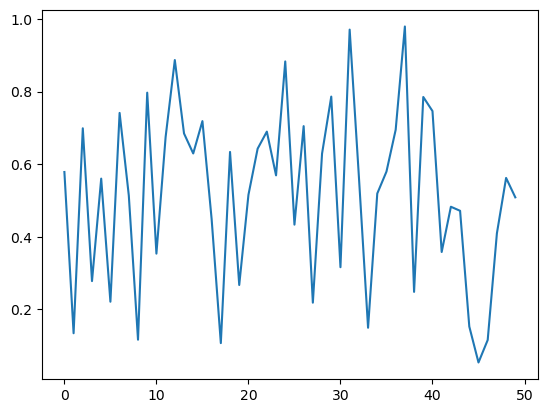

In [20]:
plt.plot(np.arange(50), rng.uniform(0,1,50))

In [7]:
def global_corr_v1(sims, refs, period):
    num_channels = len(sims)
    
    # compute all possible correlation maximizers
    lags = np.unique(np.concatenate([(sim[None,:] - ref[:,None]).flatten() for sim, ref in zip(sims, refs)]) % period)
    # TODO: rewrite global correlation function
    corr = np.zeros(1 + lags.size) # 1 for the case where t is empty
    for sim, ref in zip(sims, refs):
        if ((sim.shape[0] == 0) != (ref.shape[0] == 0)): # exactly one spike train is empty
            continue

        if (sim.shape[0] == 0) and (ref.shape[0] == 0): # both spike trains are empty
            corr[1:] += 1
            continue

        t = (sim[None,:] - ref[:,None]).flatten()
        corr[1:] += kernel(mod(lags[None,:] - t[:,None], period, -period/2)).sum(axis=0) / max(sim.shape[0], ref.shape[0])
    
    argmax = np.argmax(corr)
    if argmax == 0:
        return np.array(0.0), np.array(0.0)

    return corr[argmax] / num_channels, mod(lags[argmax-1], period, -period/2)

In [8]:
def global_corr_v2(sims, refs, period):
    Z = np.maximum([ref.size for ref in refs], [sim.size for sim in sims])
    Zmax = np.max(Z)
    
    refs_arr = np.stack([np.pad(ref, (0, Zmax - ref.size),  'constant', constant_values=np.nan) for ref in refs])
    sims_arr = np.stack([np.pad(sim, (0, Zmax - sim.size),  'constant', constant_values=np.nan) for sim in sims])
    
    lags = np.concatenate([(sim[None,:] - ref[:,None]).flatten() for ref, sim in zip(refs, sims)])
    corr = np.mean(np.nansum(kernel(mod(lags[:,None,None] - (sims_arr - refs_arr)[None,:,:], period, -period/2)), axis=-1) / Z, axis=-1)
    
    argmax = np.argmax(corr)
    return corr[argmax], mod(lags[argmax], period, -period/2)

In [9]:
global_corr_v1(sims, refs, period)

NameError: name 'kernel' is not defined

In [10]:
global_corr_v2(sims, refs, period)

NameError: name 'kernel' is not defined

In [14]:
global_correlation(refs, sims, period)

(0.9111111111111113, 1.0999999999999996)

In [14]:
sim = np.concatenate([sim1, sim2 + period])

In [15]:
ref = np.concatenate([ref1, ref2 + period])

In [71]:
Z = np.maximum([ref.size for ref in refs], [sim.size for sim in sims])


array([3, 3, 4])

In [18]:
eps = 1
kernel = lambda x_: (np.abs(x_) < eps) * (eps - np.abs(x_)) / eps


In [27]:
kernel((sim - ref)[:,None] - lags[None,:])

array([[-0. , -0. , -0. , -0. ,  0. , -0. , -0. , -0. ,  0. , -0. , -0. ,
        -0. ,  0.1],
       [ 0. , -0. , -0. , -0. , -0. , -0. , -0. ,  0.3, -0. , -0. , -0. ,
        -0. , -0. ],
       [ 0. , -0. , -0. , -0. , -0. , -0. , -0. ,  0.3, -0. , -0. , -0. ,
        -0. , -0. ],
       [-0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. , -0. ,  0.4, -0. ,
        -0. , -0. ],
       [ 0.1, -0. , -0. , -0. , -0. , -0. , -0. ,  0.4, -0. , -0. , -0. ,
        -0. , -0. ]])